# 프로젝트 8 : 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보자

- 추상적 요약을 하는 경우 : text = 본문, headlines = 요약된 데이터
- 추출적 요약을 하는 경우 : text열만 사용

# Step 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [106]:
data.sample(10)

,headlines,text
1040,"Feel responsible, had sleepless nights: Karan ...","Karan Johar, while opening up about the contro..."
33642,AAP leader calls Yogi 'nikamma' CM over van-tr...,Slamming Uttar Pradesh CM Yogi Adityanath over...
84652,Google slammed by court over users' right to b...,A German court has lashed out at Google via le...
35067,I'm the equal of Putin: French Prez boasts Syr...,Boasting the missile strikes on Russian ally S...
95062,New-found solar system may be uninhabitable du...,Hungary-based researchers studying the newly d...
92421,Five Madhesi parties unite ahead of local poll...,Five Madhesi parties on Thursday announced the...
66434,"Shilpa, Sridevi, Raveena celebrated Karva Chau...","Actress Shilpa Shetty, Sridevi and Raveena Tan..."
33349,Fan banned from stadium hires crane to watch h...,"A fan of Turkish football club Denizlispor, wh..."
70095,UK starts probe into money laundering charges ...,UK's Serious Fraud Office (SFO) has reportedly...
66675,"U-17 WC organisers goof up, forget to felicita...",PM Narendra Modi ended up felicitating former ...


# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고해 각자 필요하다고 생각하는 전처리를 추가로 사용해 텍스트를 정규화 또는 정제

만약 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 제거해야할지 고민해보자

## (1) 데이터 정리

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [107]:
# 데이터의 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [108]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿔줌
# 요약은 중복이 되어도 되지만 text는 안됨 
# 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


데이터에 null값이 남아있는지 확인, .isnull().sum()

In [109]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null값이 없음

샘플수는 총 98401 -> 98360개로 줄었음

### 텍스트 정규화와 불용어 제거


In [7]:
# 텍스트 정규화를 위해 사전을 구성한다
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


자연어 처리의 성능을 높이기 위해 불용어 제거해보자

- 소문자 변환, br등 html 태그 제거, 괄호 안 단어 제거, 특수문자 제거

- 함수 하단에 Text 전처리시에만 불용어를 제거하는 파트를 추가(summary 전처리에는 호출되지 않도록) if remove_stopwards() 사용

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"','', sentence) # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경.
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않는다

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [12]:
# 훈련 데이터 전처리 수행
# text는 불용어 제거 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical 

In [15]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) # false를 넣어준다

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [17]:
# 다시 빈 샘플 확인해보기
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

## (2) 훈련데이터와 테스트데이터 나누기

### 샘플의 최대 길이 정하기
- 필요 없는 단어를 모두 제거했으니까 샘플의 최대 길이를 정해준다
- text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해보자

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


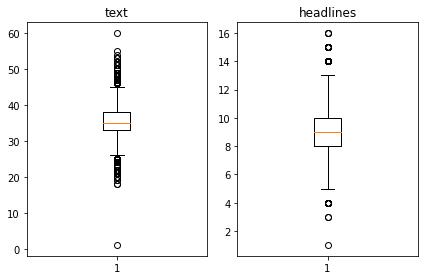

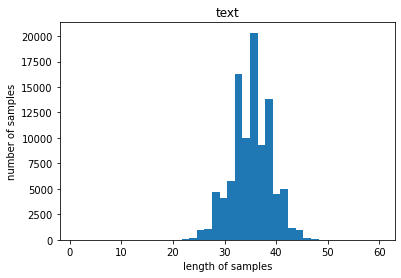

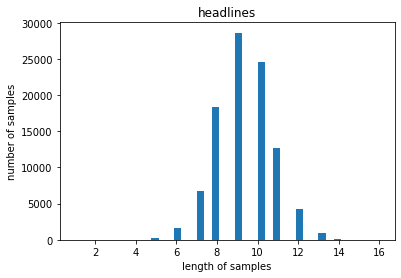

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정하자
text_max_len = 40
headlines_max_len = 12

In [20]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 알아보자
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
# text, headlines 적용
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89775


### 시작 토큰과 종료 토큰 추가하기

- seq2seq훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야한다.
- headlines에 sostoken, eostoken추가

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [25]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 numpy타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 훈련 데이터와 테스트 데이터 분리
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[11975 38679 86441 ... 32923 22442 30989]


In [27]:
# 정수 시퀀스를 이용해 다시 샘플 순서를 정의해주면 잘 섞인 샘플이 된다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
# 훈련:테스트 -> 8:2로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17955


In [29]:
# 전체 데이터를 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


## (3) 정수 인코딩 - 단어 집합(vocabulary) 만들기 및 정수 인코딩

keras의 토크나이저 사용해서 encoder_input_train에 대해 단어집합 구성해준다

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [39]:
# 빈도수 9회 미만의 단어가 차지하는 비중 확인

threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65709
등장 빈도가 8번 이하인 희귀 단어의 수: 47368
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18341
단어 집합에서 희귀 단어의 비율: 72.08753747584045
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.455903512620658


In [40]:
# 제외한 단어집합의 크기가 18341이었으므로 대충 18000개로 제한한다.
src_vocab = 18000          
src_tokenizer = Tokenizer(num_words=src_vocab) # num_words로 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 = 정수 인코딩(18000이상의 숫자들은 없어진다)
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[305, 1154, 319, 607, 457, 183, 15, 8876, 3993, 37, 16, 1001, 248, 59, 1, 6397, 1255, 11118, 1199, 361, 457, 219, 198, 176, 1157, 177, 315, 248, 1, 16488, 117, 5180], [83, 123, 12, 4801, 138, 489, 3315, 47, 5073, 3481, 7492, 10292, 2520, 15059, 3203, 7, 1, 58, 4801, 5073, 1154, 202, 3966, 1540, 154, 435, 9580, 70, 403, 45, 433, 362, 1962, 508], [15, 20, 49, 362, 424, 2849, 1344, 69, 1, 471, 3883, 593, 103, 499, 3415, 6316, 6952, 6316, 10546, 925, 121, 1449, 252, 8, 499, 3415, 53, 1397, 3731, 1546, 599, 11119, 55, 428, 23]]


In [42]:
# headlines 데이터에도 동일하게 작업 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
# 등장 빈도수 8회 미만으로 확인
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28795
등장 빈도가 7번 이하인 희귀 단어의 수: 20452
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8343
단어 집합에서 희귀 단어의 비율: 71.02621982983158
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.295415627253383


In [46]:
# 8000으로 제한하고 제거
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 916, 748, 264, 7, 166, 42, 2812], [1, 5841, 112, 7260, 9, 3998, 6471, 3, 5553, 2758, 4, 444], [1, 265, 3430, 179, 5084, 5296, 1422, 2584, 22], [1, 3999, 6, 1009, 2071, 569, 51, 93, 11, 38, 55], [1, 2759, 1881, 3025, 4, 8]]
target
decoder  [[916, 748, 264, 7, 166, 42, 2812, 2], [5841, 112, 7260, 9, 3998, 6471, 3, 5553, 2758, 4, 444, 2], [265, 3430, 179, 5084, 5296, 1422, 2584, 22, 2], [3999, 6, 1009, 2071, 569, 51, 93, 11, 38, 55, 2], [2759, 1881, 3025, 4, 8, 2]]


정수 인코딩 후, 패딩 작업 전 점검 사항

- 전체 데이터에서 빈도수가 낮은 단어가 삭제된 것은 빈 샘플이 생겼을 가능성이 높아졌음을 의미
- 특히 headlines 

headlines중 길이가 0이 된 샘플의 인덱스를 받아온다

주의할 점 : headlines인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높다. 그래서 단어집합 제한에도 삭제되지 않을 것임

그러니까 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이다

In [47]:
# 훈련과 테스트 데이터에서 요약문 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장
# 삭제할것임
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71819
훈련 레이블의 개수 : 71819
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


### 패딩하기


In [50]:
# 최대 길이보다 짧은 데이터들은 뒤에 0을 넣어서 길이 맞춰준다
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

학습용 데이터 전처리 완료

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## (1) 모델 설계하기

In [56]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터 차원 128
hidden_size = 256   # hidden state는 용량의 크기, LSTM에서의 뉴련의 개수

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 128)      2304000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 40, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## (2) 모델 훈련하기

In [57]:
# 설계한 모델로 훈련 진행하기

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 특정 조건이 충족되면 훈련을 멈추는 역할
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
141/141 [==============================] - 91s 590ms/step - loss: 5.6562 - val_loss: 5.2853
Epoch 2/50
141/141 [==============================] - 82s 581ms/step - loss: 5.1348 - val_loss: 4.9238
Epoch 3/50
141/141 [==============================] - 82s 583ms/step - loss: 4.8374 - val_loss: 4.7193
Epoch 4/50
141/141 [==============================] - 82s 585ms/step - loss: 4.5914 - val_loss: 4.4938
Epoch 5/50
141/141 [==============================] - 82s 583ms/step - loss: 4.3729 - val_loss: 4.3383
Epoch 6/50
141/141 [==============================] - 82s 582ms/step - loss: 4.1937 - val_loss: 4.2154
Epoch 7/50
141/141 [==============================] - 82s 582ms/step - loss: 4.0434 - val_loss: 4.0984
Epoch 8/50
141/141 [==============================] - 82s 580ms/step - loss: 3.9092 - val_loss: 4.0230
Epoch 9/50
141/141 [==============================] - 83s 585ms/step - loss: 3.7899 - val_loss: 3.9441
Epoch 10/50
141/141 [==============================] - 82s 582ms/step - l

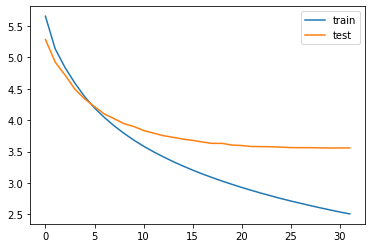

In [59]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## (3) 인퍼런스 모델 구현

- 테스트 단계에서 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야함
- 3개의 사전 미리 준비

In [60]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행
- 훈련 단계 : 인코더와 디코더를 엮은 하나의 모델 준비
- 정답이 없는 인퍼런스 단계 : 인코더와 디코더를 분리해서 설계

In [61]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [97]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 40, 128)           2304000   
_________________________________________________________________
lstm_8 (LSTM)                [(None, 40, 256), (None,  394240    
_________________________________________________________________
lstm_9 (LSTM)                [(None, 40, 256), (None,  525312    
_________________________________________________________________
lstm_10 (LSTM)               [(None, 40, 256), (None,  525312    
Total params: 3,748,864
Trainable params: 3,748,864
Non-trainable params: 0
_________________________________________________________________


In [98]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

## 모델 테스트하기

In [99]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [100]:
# 테스트 데이터 약 50개의 샘플에 대해 실제 요약과 예측된 요약 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : recalling getting sweeping test new zealand ex australia leg spinner shane warne said still genuinely asks go single adding silence dressing room warne said walked straight shower area lit cigarette beer went idiot everyone started laughing 
실제 요약 : had beer cigarette went you idiot warne on getting out at 
예측 요약 :  never knew about me warne on australian pacer


원문 : indian railways stop providing free travel insurance ticket passengers september year senior railways ministry official said saturday booking tickets passengers choose two options either opt opt travel insurance amount travel insurance disclosed yet 
실제 요약 : railways to free travel insurance from sept 
예측 요약 :  railways to charge extra for booking of tickets


원문 : us government network infected malware employee accessed porn sites work computer investigators found audit revealed unnamed employee visited thousands porn pages containing malware downloaded laptop exploited network employee android phone connected gover

예측 요약 :  bjp will not ally with any party in tmc


원문 : apple vp software engineering craig mocked google android operating system company event said ios users currently running ios android users last oreo version look competition hard say really software update model added 
실제 요약 : apple mocks android on stage at event 
예측 요약 :  apple ios ios to remove ios from ios


원문 : scientists upper limit cosmic optical background total amount light produced galaxies universe measurements made using nasa new horizons spacecraft currently beyond pluto belt findings would reveal number location stars also giving insights dark matter scientists said 
실제 요약 : scientists measure of universe with nasa probes 
예측 요약 :  astronomers spot planets in milky way for st time


원문 : pop marriage licence kiosk opened las vegas airport passengers wishing get married several couples already gotten married pop kiosk remain open february meanwhile couples must pay marriage licence 
실제 요약 : passengers can get marria

예측 요약 :  japan to get coaches of coaches of athletes


원문 : year old woman named ellen fleming boston us became millionaire minutes recently million mistakenly transferred bank account woman informed concerned financial consultant found million account instead money actually meant another woman name florida 
실제 요약 : us woman becomes millionaire for minutes after account up 
예측 요약 :  woman who got credit card gets credit for hacking


원문 : india captain virat kohli currently batsman world average across three formats kohli average currently highest world second highest odis test average touched century sri lanka first test galle 
실제 요약 : kohli world only player with average in all 
예측 요약 :  kohli has yo yo test for most straight year


원문 : uk vedanta resources invest around billion india next years expand metals mining businesses billionaire chairman anil agarwal said agarwal said investments create million jobs directly indirectly added large part directed towards oil gas increase pro

# Step 5. Summa을 이용해서 추출적 요약해보기

- 추상적 요약 : 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다
- 추출적 요약 : 추상적 요약보다 난이도가 낮고 잘못된 요약이 나올 가능성이 낮다
- Summa의 summarize를 사용

In [110]:
import requests
from summa.summarizer import summarize

In [111]:
text = data['text']
print(text[:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1495    India head coach Ravi Shastri has said that he...
1496    Italian tennis player Andreas Seppi ensured hi...
1497    World number three Roger Federer was stopped b...
1498    A cutout of TMC chief and West Bengal CM Mamat...
1499    A Delhi court on Saturday pulled up Delhi Poli...
Name: text, Length: 1500, dtype: object


In [112]:
text[10]

"Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture."

In [130]:
print('Headlines:')
print(summarize(text[10], words=20))

Headlines:
Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


In [131]:
for _ in range(10):
    random_n = np.random.randint(len(text))
    print("\n")
    print("Text :")
    print(text[random_n])     #원문의 0.5%만 출력, 요약문 크기 조절
    print("\n")
    print("Headlines :")
    print(summarize(text[random_n], ratio=0.5))
    print("\n")
    print("--------------------------------------------------------------------------------------------------------")



Text :
After he accused China of trying to interfere in the upcoming US congressional elections, President Donald Trump said he and Chinese President Xi Jinping might not be friends anymore. "But I think he [Xi Jinping] probably respects me," Trump added. Notably, the US leader has spoken of his friendship with Xi many times since he took office.


Headlines :
"But I think he [Xi Jinping] probably respects me," Trump added.


--------------------------------------------------------------------------------------------------------


Text :
The partnership between the world's oldest democracy the US and world's largest democracy India could be the defining partnership of the 21st century, ex-US President Barack Obama has said. India and the US are hugely diverse and have got different languages, backgrounds and faiths but what they have in common is the values they believe in deeply, Obama added.


Headlines :
The partnership between the world's oldest democracy the US and world's large